In [676]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

In [677]:
data = pd.read_csv("./water.csv", parse_dates=["Дата"]).replace("-", np.NaN)
data["Температура воды"] = data["Температура воды"].astype(float)


In [678]:
extra = interp1d(
    data["Дата"][3:].astype("int64"),
    data["Температура воды"][3:],
    kind="quadratic",
    fill_value="extrapolate",
)
data.loc[:2, "Температура воды"] = extra(data[:3]["Дата"].astype("int64")).copy()


In [679]:
new_index = pd.date_range(
    start=data["Дата"][0], end=data["Дата"][len(data) - 1], freq="H"
)
new_data = pd.DataFrame(
    {
        "Дата": new_index,
        "Уровень воды": None,
        "Изменение уровня воды": None,
        "Температура воды": None,
    }
)

mask = new_data["Дата"].apply(lambda x: x.hour == 0)
for col in new_data.columns[1:]:
    new_data.loc[mask, col] = data[col].copy()


In [680]:
interpolated = interp1d(
    data["Дата"].astype("int64"),
    data["Температура воды"],
    kind="quadratic",
    fill_value="extrapolate",
)

# Получаем интерполированные значения для нового DataFrame
interpolated_temperatures = interpolated(new_data["Дата"].astype("int64"))

# Создаем DataFrame с интерполированными данными
new_data["Температура воды"] = interpolated_temperatures


In [681]:
interpolated = interp1d(
    data["Дата"].astype("int64"),
    data["Уровень воды"],
    kind="quadratic",
    fill_value="extrapolate",
)

# Получаем интерполированные значения для нового DataFrame
interpolated_temperatures = interpolated(new_data["Дата"].astype("int64"))

# Создаем DataFrame с интерполированными данными
new_data["Уровень воды"] = interpolated_temperatures


In [682]:
X = data["Температура воды"].values
y = data["Уровень воды"].values


Text(0, 0.5, 'Уровень воды')

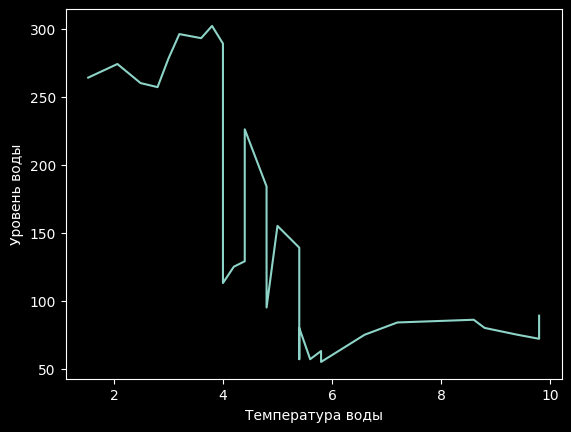

In [683]:
y = y[X.argsort()]
X = X[X.argsort()]
plt.plot(X, y)
plt.xlabel("Температура воды")
plt.ylabel("Уровень воды")


И так, у нас получились изначальные значения

Прогоним их через средние на каждом отрезке $0.5$

c:\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


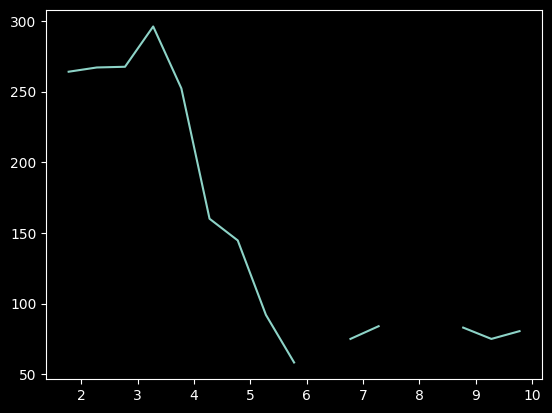

In [684]:
step = 0.5
X2 = []
y2 = []
for i in np.arange(min(X), max(X), step):
    X2.append(i + step / 2)
    y2.append(np.mean(y[(X >= i) & (X < i + step)]))

X2 = np.array(X2)
y2 = np.array(y2)

plt.plot(X2, y2)

Выкинем все `nan`

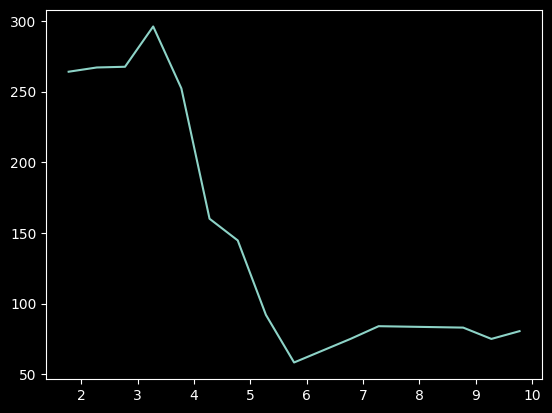

In [685]:
X2 = X2[~np.isnan(y2)]
y2 = y2[~np.isnan(y2)]
plt.plot(X2, y2)

Возьмем среднюю скользящую

In [686]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n


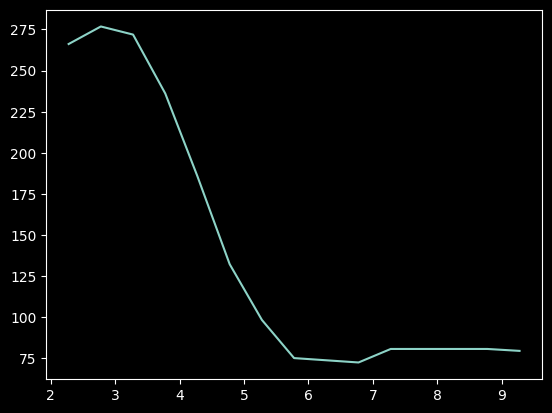

In [687]:
X2, y2 = X2[1:-1], moving_average(y2)
plt.plot(X2, y2)

Масштабируем значения в пределах от 0 до 1 и сделаем возрастающеми

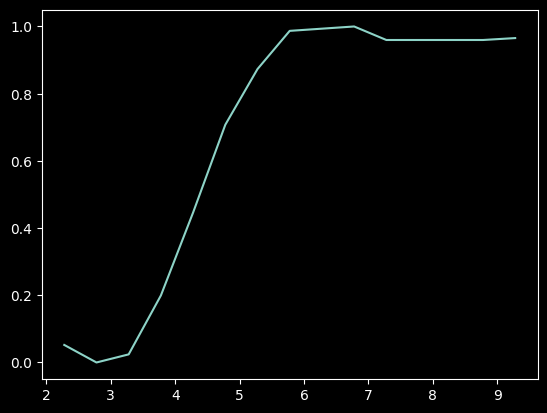

In [688]:
shift = min(y2)
y2 = y2 - shift
scale = max(y2)
y2 /= scale
y2 = 1 - y2
plt.plot(X2, y2)

Уберем выбрасы, места где y начинает падать

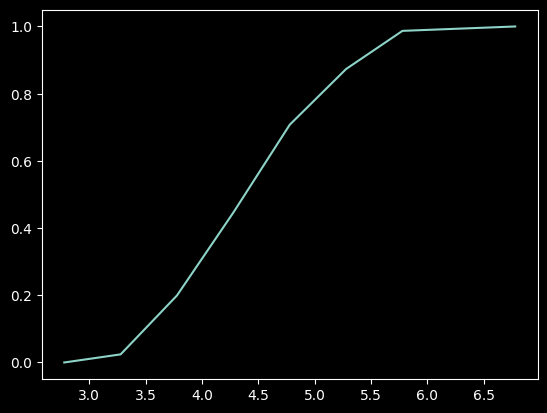

In [689]:
y2 = y2[(X2 > 2.5) & (X2 < 7)]
X2 = X2[(X2 > 2.5) & (X2 < 7)]
plt.plot(X2, y2)


Мы строим сигмоиду, так что немного математики

$$
y = \dfrac{1}{1 + e^{bX+c}}
$$

$$
\dfrac{1}{y} = 1 + e^{bX+c}
$$

$$
\dfrac{1}{y} - 1 = e^{bX+c}
$$

$$
\ln(\dfrac{1}{y} - 1) = bX+c
$$

Приведем `y` к линейному виду и уберем выбросы

C:\Users\DaSh-More\AppData\Local\Temp\ipykernel_25528\4230628368.py:1: RuntimeWarning: divide by zero encountered in divide
  y2 = np.log(1 / y2 - 1)
C:\Users\DaSh-More\AppData\Local\Temp\ipykernel_25528\4230628368.py:1: RuntimeWarning: divide by zero encountered in log
  y2 = np.log(1 / y2 - 1)


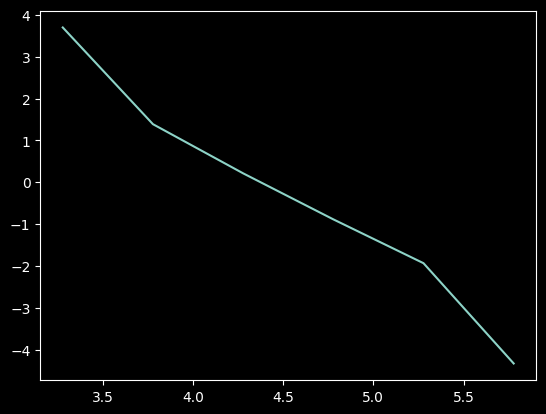

In [690]:
y2 = np.log(1 / y2 - 1)

X2 = X2[~np.isinf(y2)]
y2 = y2[~np.isinf(y2)]
plt.plot(X2, y2)


Построим модель и предскажем значения

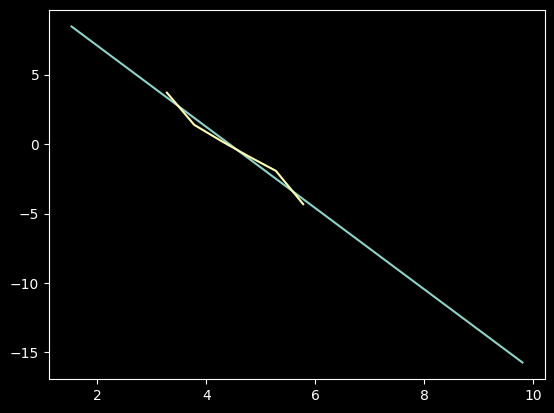

In [691]:
model = LinearRegression().fit(X2[:, None], y2)
y_pred = model.predict(X[:, None])
plt.plot(X, y_pred)
plt.plot(X2, y2)


Масштабируем данные обратно и строим график

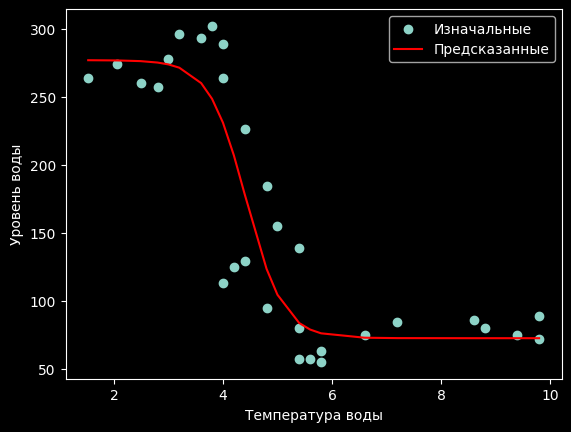

In [692]:
y_pred = (1 - 1 / (1 + np.e**y_pred)) * scale + shift

plt.scatter(X, y)
plt.plot(X, y_pred, c="r")
plt.xlabel("Температура воды")
plt.ylabel("Уровень воды")
plt.legend(["Изначальные", "Предсказанные"])
